In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os,gc,re,time
import matplotlib.pyplot as plt
import seaborn as sns
import spacy,random
from collections import Counter
import warnings,unicodedata
warnings.simplefilter("ignore")


#setting device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Available device: {device}')

Available device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/NLP/Machine Translation')
# os.chdir('/content/drive/MyDrive/Colab Notebooks/MTranslation')


As first step we will generate csv files for Multi30k dataset. We will generate
* train.csv
* val.csv
* test.csv

## Generating csv from text files

In [ ]:

!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
!pip3 install https://github.com/explosion/spacy-models/releases/download/de_core_news_sm-2.2.0/de_core_news_sm-2.2.0.tar.gz

In [ ]:
def combine_csv(csv_path,eng_csv_path,ger_csv_path):
    df1 = pd.read_csv(eng_csv_path)
    df2 = pd.read_csv(ger_csv_path)
    df1["Ger"] = df2["Ger"]
    del df2
    return df1


def csv_generator(csv_path,file_paths):
    eng_csv_path = 'tmp1.csv'
    ger_csv_path = 'tmp2.csv'
    data_eng = open(eng_csv_path,'w')
    data_ger = open(ger_csv_path,'w')

    data_eng.write('English')
    data_eng.write('\n')
    data_ger.write('Ger')
    data_ger.write('\n')

    with open(file_paths[0],'r') as ger, open(file_paths[1],'r') as eng:
        i = 0
        for line_ger, line_eng in zip(ger,eng):

            line_ger_,line_eng_ = line_ger.strip(),line_eng.strip()
            line_ger_,line_eng_ = re.sub('[,]',' ',line_ger_),re.sub('[,]',' ',line_eng_)

            data_eng.write(line_eng_)
            data_eng.write('\n')
            data_ger.write(line_ger_)
            data_ger.write('\n')
          
            i += 1
    
    data_eng.close()
    data_ger.close()
    df = combine_csv(csv_path,eng_csv_path,ger_csv_path)
    df.to_csv(csv_path,index=False)
    os.remove(eng_csv_path)
    os.remove(ger_csv_path)
    print(f'Data Generation ({csv_path}) Completed....')
    

In [ ]:
# create csv
import glob
dir_path = 'data'

files_ = os.listdir(dir_path)

train_files = glob.glob(dir_path+'/train.*')
val_files = glob.glob(dir_path+'/val.*')
test_files = glob.glob(dir_path+'/test.*')
train_files.sort()
val_files.sort()
test_files.sort()

train_csv_path,val_csv_path,test_csv_path = 'data/train.csv','data/val.csv','data/test.csv'


csv_generator(train_csv_path,train_files)
csv_generator(val_csv_path,val_files)
csv_generator(test_csv_path,test_files)

Now we have our csv files generated. Let us start our analyis


### Basic analysis

In [4]:

train_csv_path,val_csv_path,test_csv_path = 'data/train.csv','data/val.csv','data/test.csv'

df_train = pd.read_csv(train_csv_path)
df_val = pd.read_csv(val_csv_path)
df_test = pd.read_csv(test_csv_path)

print(df_train.shape,df_val.shape,df_test.shape)

(29000, 2) (1014, 2) (1000, 2)


In [5]:
df_train.head()

,English,Ger
0,Two young White males are outside near many b...,Zwei junge weiße Männer sind im Freien in der ...
1,Several men in hard hats are operating a giant...,Mehrere Männer mit Schutzhelmen bedienen ein A...
2,A little girl climbing into a wooden playhouse.,Ein kleines Mädchen klettert in ein Spielhaus ...
3,A man in a blue shirt is standing on a ladder ...,Ein Mann in einem blauen Hemd steht auf einer ...
4,Two men are at the stove preparing food.,Zwei Männer stehen am Herd und bereiten Essen zu.


In [6]:
df_val.head()

,English,Ger
0,A group of men are loading cotton onto a truck,Eine Gruppe von Männern lädt Baumwolle auf ein...
1,A man sleeping in a green room on a couch.,Ein Mann schläft in einem grünen Raum auf eine...
2,A boy wearing headphones sits on a woman's sho...,Ein Junge mit Kopfhörern sitzt auf den Schulte...
3,Two men setting up a blue ice fishing hut on a...,Zwei Männer bauen eine blaue Eisfischerhütte a...
4,A balding man wearing a red life jacket is sit...,Ein Mann mit beginnender Glatze der eine rote...


In [7]:
df_test.head()

,English,Ger
0,A man in an orange hat starring at something.,Ein Mann mit einem orangefarbenen Hut der etw...
1,A Boston Terrier is running on lush green gras...,Ein Boston Terrier läuft über saftig-grünes Gr...
2,A girl in karate uniform breaking a stick with...,Ein Mädchen in einem Karateanzug bricht ein Br...
3,Five people wearing winter jackets and helmets...,Fünf Leute in Winterjacken und mit Helmen steh...
4,People are fixing the roof of a house.,Leute Reparieren das Dach eines Hauses.


In [11]:
print(df_train.info())
print('_'*30)
print(df_val.info())
print('_'*30)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29000 entries, 0 to 28999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   English  29000 non-null  object
 1   Ger      29000 non-null  object
dtypes: object(2)
memory usage: 453.2+ KB
None
______________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   English  1014 non-null   object
 1   Ger      1014 non-null   object
dtypes: object(2)
memory usage: 16.0+ KB
None
______________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   English  1000 non-null   object
 1   Ger      1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB
None



Let us check for null values and duplicates
### Checking null values and duplicates

In [12]:
df_train.isnull().sum()

English    0
Ger        0
dtype: int64

In [13]:
df_train[df_train.duplicated()]

,English,Ger
14214,A dog swims in the water.,Ein Hund schwimmt im Wasser.
16866,A dog runs through the woods.,Ein Hund rennt durch den Wald.
20148,A dog swimming with a stick in its mouth.,Ein Hund schwimmt mit einem Stock im Maul.


We have some null values.We will drop those values

In [14]:
# we will drop duplicates
df_train = df_train.drop_duplicates()

In [15]:
# checking duplicates in validation data
df_val[df_val.duplicated()]

,English,Ger


In [16]:
# checking duplicates in test data
df_test[df_test.duplicated()]

,English,Ger




### Clean text


Now let us write code to clean the text data.
For english data:
* We will remove special charecters.
* Replace words with base fom like don't with do not, shouldn't with should not etc
* We will remove extra spaces
* Converts every word to lower case

For german text:
* We will remove extra spaces
* We will remove special charecters at the end of the word like '.', '?' etc

In [17]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

replace_dict = {"don't": "do not","shouldn't": "should not",
         "can't": "cannot", "I'm": "Iam", "I've": "I have",
         "haven't": "have not",
         "hasn't": "has not", 
         "didn't": "did not"}

def clean_eng_text(text):
      text = unicodeToAscii(text.lower().strip())
      # remove some special charecters
      text = re.sub('[-?<>.!]','',text)
      # remove extra spaces
      text = re.sub('\s+',' ',text)
      text = ' '.join([replace_dict[word] if word in replace_dict.keys() else word for word in text.split()])

      text = [re.sub('[^A-Za-z]','',word) for word in text.split()]
      return ' '.join(text).lower()


print('English')
text = df_train['English'].iloc[115]
print('Original text:')
print(text)
print('--'*25)
print('Cleaned text:')
x = clean_eng_text(text)
print(x)

English
Original text:
A man and his dog are grilling green beans on a grill.
--------------------------------------------------
Cleaned text:
a man and his dog are grilling green beans on a grill


In [18]:

def clean_ger_text(text):
    text = text.strip()
    text = re.sub("[.?]"," ",text)
    text = re.sub('\s+',' ',text)
    text = text.strip()
    return text

print('German')
text = df_train['Ger'].iloc[115]
print('Original text:')
print(text)
print('--'*25)
print('Cleaned text:')
x = clean_ger_text(text)
print(x)

German
Original text:
Ein Mann und sein Hund grillen grüne Bohnen auf einem Grill.
--------------------------------------------------
Cleaned text:
Ein Mann und sein Hund grillen grüne Bohnen auf einem Grill


In [19]:
df_train["English"] = df_train["English"].apply(lambda x: clean_eng_text(x))
df_train["Ger"] = df_train["Ger"].apply(lambda x: clean_ger_text(x))

### Analyzing Sequence lengths
Now let us analyze the sequence length of both english and german text.

In [21]:
df_train['eng_seq_length'] = df_train["English"].apply(lambda x: len(x.split()))
df_train['ger_seq_length'] = df_train["Ger"].apply(lambda x: len(x.split()))

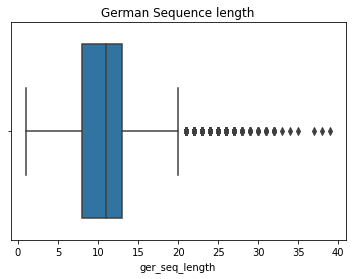



10th Percentile value : 7.0
20th Percentile value : 8.0
30th Percentile value : 9.0
40th Percentile value : 10.0
50th Percentile value : 11.0
60th Percentile value : 11.0
70th Percentile value : 13.0
80th Percentile value : 14.0
90th Percentile value : 16.0
100th Percentile value : 39.0
----------------------------------------------------------------------------------------------------
90th Percentile value : 16.0
91th Percentile value : 16.0
92th Percentile value : 17.0
93th Percentile value : 17.0
94th Percentile value : 18.0
95th Percentile value : 18.0
96th Percentile value : 19.0
97th Percentile value : 20.0
98th Percentile value : 21.0
99th Percentile value : 23.0
100th Percentile value : 39.0
----------------------------------------------------------------------------------------------------
99.1th Percentile value : 23.0
99.2th Percentile value : 23.0
99.3th Percentile value : 24.0
99.4th Percentile value : 24.0
99.5th Percentile value : 25.0
99.6th Percentile value : 25.0
99

In [23]:
sns.boxplot(df_train["ger_seq_length"])
plt.title('German Sequence length')
plt.show()

print('\n')

# Printing Percentiles :
for i in range(10, 101, 10):
    print("{}th Percentile value : {}".format(i, np.percentile(df_train["ger_seq_length"], i)))
    
print('--'*50)
for i in range(90, 101):
    print("{}th Percentile value : {}".format(i, np.percentile(df_train["ger_seq_length"], i)))

print('--'*50)
for i in range(1, 11):
    print("{}th Percentile value : {}".format((i*1.0/10 + 99), np.percentile(df_train["ger_seq_length"], i*1.0/10 + 99)))

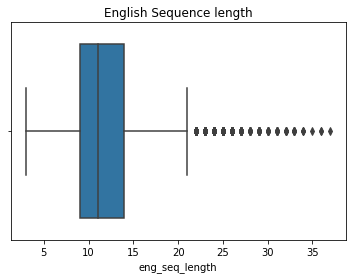



10th Percentile value : 8.0
20th Percentile value : 9.0
30th Percentile value : 10.0
40th Percentile value : 10.0
50th Percentile value : 11.0
60th Percentile value : 12.0
70th Percentile value : 13.0
80th Percentile value : 15.0
90th Percentile value : 17.0
100th Percentile value : 37.0
----------------------------------------------------------------------------------------------------
90th Percentile value : 17.0
91th Percentile value : 17.0
92th Percentile value : 18.0
93th Percentile value : 18.0
94th Percentile value : 18.0
95th Percentile value : 19.0
96th Percentile value : 19.159999999999854
97th Percentile value : 20.0
98th Percentile value : 21.0
99th Percentile value : 23.0
100th Percentile value : 37.0
----------------------------------------------------------------------------------------------------
99.1th Percentile value : 24.0
99.2th Percentile value : 24.0
99.3th Percentile value : 24.0
99.4th Percentile value : 25.0
99.5th Percentile value : 25.0
99.6th Percentile 

In [22]:
sns.boxplot(df_train["eng_seq_length"])
plt.title('English Sequence length')
plt.show()

print('\n')

# Printing Percentiles :
for i in range(10, 101, 10):
    print("{}th Percentile value : {}".format(i, np.percentile(df_train["eng_seq_length"], i)))
    
print('--'*50)
for i in range(90, 101):
    print("{}th Percentile value : {}".format(i, np.percentile(df_train["eng_seq_length"], i)))

print('--'*50)
for i in range(1, 11):
    print("{}th Percentile value : {}".format((i*1.0/10 + 99), np.percentile(df_train["eng_seq_length"], i*1.0/10 + 99)))

We will take 23 as maxiumum for english and 23 for german. It is needed because it is better to have a fixed sequence length before passing to the model. We will do pading and truncation respectively if sequence length is smaller or larger than the maximum sequence length.


### Tokenization and Vocab Creation

Next we will generate tokens from this text data and generate sequences from it. 
Some important takeaways regarding tokenization and vocab creation

- For tokenizing english text and german text we use spacy library. If the word is present in spacy corpus we will use that word else we use <UNK> token.
        
- Later in both cases these tokens are mapped to a integer value to generate a sequence.
    
- We will also set a minimum frequency(for example 2). ie, if a word is repeating only 2 times, we will use it for creating the sequence.Otherwise we will again use UNK token.

- We start every sequence with SOS token and end with EOS token. These are important in tasks like machine translation.
    
- Earlier we have checked sequence length.Based on that We will pad both input and output sequence to a fixed length.


In [20]:
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 14.9 MB 5.4 MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-py3-none-any.whl size=14907055 sha256=87d383abde47f02d9be72a96926a600abe5baef3659cbe9e83a148290d800c27
  Stored in directory: /tmp/pip-ephem-wheel-cache-1g17i802/wheels/00/66/69/cb6c921610087d2cab339062345098e30a5ceb665360e7b32a
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
     |████████████████████████████████| 12.0 MB 5.5 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
import en_core_web_sm,de_core_news_sm

class VocabGenerator:
    def __init__(self, corpus, min_frequency=2, tokenizer_lang="english"):
        self.stoi = {'<UNK>':1,'<PAD>':0,'<SOS>':2,'<EOS>':3}
        self.itos = {1:'<UNK>',0:'<PAD>',2:'<SOS>',3:'<EOS>'}
        self.min_freq = min_frequency
        #tokenizer
        self.lang = tokenizer_lang
        if tokenizer_lang == "english":
            self.tokenizer = en_core_web_sm.load()
        else:
            self.tokenizer = de_core_news_sm.load()

        self.build_vocabulary(corpus)
    
    def __len__(self):
        return len(self.itos)
    
    def build_vocabulary(self,corpus):
        idx = 4
        frequency_dict = Counter(corpus.split())
        for word,freq in frequency_dict.items():
          if freq >= self.min_freq:
              self.stoi[word] = idx
              self.itos[idx] = word
              idx += 1

    def generate_numeric_tokens(self,text):
        
        tokenized_out = [token.text for token in self.tokenizer(text)]
        out = [self.stoi[token] if token in self.stoi.keys() else self.stoi["<UNK>"] for token in tokenized_out]    
        return out

    def add_eos_sos(self,numeric_list):
        numeric_list = [self.stoi['<SOS>']] + numeric_list + [self.stoi['<EOS>']] 
        return numeric_list
        
    def pad_sequence(self,numeric_list,max_seq_length):
        """
        padding and truncation
        """
        if len(numeric_list) < max_seq_length:
            no_zeros = max_seq_length - len(numeric_list)
            numeric_list = numeric_list + [self.stoi['<PAD>'] for i in range(no_zeros)]
        else:
            numeric_list = numeric_list[:max_seq_length]
        
        return numeric_list

In [ ]:
#creating corpus
corpus_eng = ' '.join(list(df_train['English'].values))
vocab_eng = VocabGenerator(corpus=corpus_eng, min_frequency=2,tokenizer_lang="english")

corpus_ger = ' '.join(list(df_train['Ger'].values))
vocab_ger = VocabGenerator(corpus=corpus_ger, min_frequency=2,tokenizer_lang="german")

# printing some vocabs
print(vocab_eng.stoi["<UNK>"],vocab_eng.stoi["not"])

# printing some vocabs
print(vocab_ger.stoi["<UNK>"])

1 85
1


In [ ]:
print(vocab_ger.stoi)

{'<UNK>': 1, '<PAD>': 0, '<SOS>': 2, '<EOS>': 3, 'Zwei': 4, 'junge': 5, 'weiße': 6, 'Männer': 7, 'sind': 8, 'im': 9, 'Freien': 10, 'in': 11, 'der': 12, 'Nähe': 13, 'vieler': 14, 'Büsche': 15, 'Mehrere': 16, 'mit': 17, 'Schutzhelmen': 18, 'bedienen': 19, 'ein': 20, 'Ein': 21, 'kleines': 22, 'Mädchen': 23, 'klettert': 24, 'Spielhaus': 25, 'aus': 26, 'Holz': 27, 'Mann': 28, 'einem': 29, 'blauen': 30, 'Hemd': 31, 'steht': 32, 'auf': 33, 'einer': 34, 'Leiter': 35, 'und': 36, 'putzt': 37, 'Fenster': 38, 'stehen': 39, 'am': 40, 'Herd': 41, 'bereiten': 42, 'Essen': 43, 'zu': 44, 'grün': 45, 'hält': 46, 'eine': 47, 'Gitarre': 48, 'während': 49, 'andere': 50, 'sein': 51, 'ansieht': 52, 'lächelt': 53, 'einen': 54, 'ausgestopften': 55, 'Löwen': 56, 'an': 57, 'schickes': 58, 'spricht': 59, 'dem': 60, 'Handy': 61, 'sie': 62, 'langsam': 63, 'die': 64, 'Straße': 65, 'Eine': 66, 'Frau': 67, 'großen': 68, 'Geldbörse': 69, 'geht': 70, 'Tor': 71, 'vorbei': 72, 'Jungen': 73, 'tanzen': 74, 'mitten': 75, 'Na

In [ ]:
print(vocab_eng.stoi)

{'<UNK>': 1, '<PAD>': 0, '<SOS>': 2, '<EOS>': 3, 'two': 4, 'young': 5, 'white': 6, 'males': 7, 'are': 8, 'outside': 9, 'near': 10, 'many': 11, 'bushes': 12, 'several': 13, 'men': 14, 'in': 15, 'hard': 16, 'hats': 17, 'operating': 18, 'a': 19, 'giant': 20, 'pulley': 21, 'system': 22, 'little': 23, 'girl': 24, 'climbing': 25, 'into': 26, 'wooden': 27, 'playhouse': 28, 'man': 29, 'blue': 30, 'shirt': 31, 'is': 32, 'standing': 33, 'on': 34, 'ladder': 35, 'cleaning': 36, 'window': 37, 'at': 38, 'the': 39, 'stove': 40, 'preparing': 41, 'food': 42, 'green': 43, 'holds': 44, 'guitar': 45, 'while': 46, 'other': 47, 'observes': 48, 'his': 49, 'smiling': 50, 'stuffed': 51, 'lion': 52, 'trendy': 53, 'talking': 54, 'her': 55, 'cellphone': 56, 'gliding': 57, 'slowly': 58, 'down': 59, 'street': 60, 'woman': 61, 'with': 62, 'large': 63, 'purse': 64, 'walking': 65, 'by': 66, 'gate': 67, 'boys': 68, 'dancing': 69, 'poles': 70, 'middle': 71, 'of': 72, 'night': 73, 'ballet': 74, 'class': 75, 'five': 76, '